In [1]:
import os
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

### Helper functions

In [2]:
def read_im(fname, data_path='./RedLights2011_Medium'):
    # read image using PIL:
    I = Image.open(os.path.join(data_path,fname))
    # convert to numpy array:
    return np.asarray(I)


def plot_with_bounding_boxes(I, bboxes, ax=None, l_width=1):
    ''' Helper function that plots image I with bounding boxes'''
    if ax is None:
        ax = plt.subplot(111)
    
    ax.imshow(I)
    
    for bbox in bboxes:
        # Create a Rectangle patch
        x1, y1, x2, y2 = bbox
        anchor = (x2, y2)
        width = (x1 - x2)
        height = (y1 - y2)
        rect = patches.Rectangle(anchor, width, height, 
                    linewidth=l_width, edgecolor='g', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        
    return ax

### Finding Red Light examples

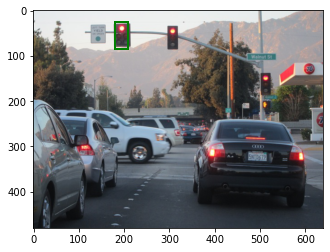

In [3]:
#rl_examples = []

fname = 'RL-012.jpg'
# We want all example boxes to be the same size
# for convenience in averaging, so we specify (30, 60)
# boxes with an anchor point
anchor = (180, 25)
filter_box = [np.arange(30, dtype=int) + anchor[0], 
              np.arange(60, dtype=int) + anchor[1]]

I = read_im(fname)
idx = np.ix_(filter_box[1], filter_box[0],[0, 1, 2])
bbox = [filter_box[0][0], filter_box[1][0],
        filter_box[0][-1], filter_box[1][-1]]
#plt.imshow(I[idx])
plot_with_bounding_boxes(I, [bbox], l_width=2);

#rl_examples += [(fname, filter_box)]
#rl_examples

### Finding non red light examples

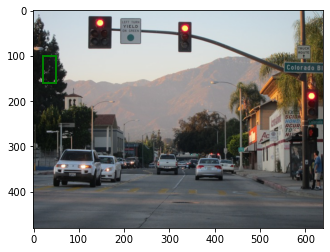

In [4]:
#non_rl_examples = []

fname = 'RL-010.jpg'
# We want all example boxes to be the same size
# for convenience in averaging, so we specify (30, 60)
# boxes with an anchor point
anchor = (20, 100)
filter_box = [np.arange(30, dtype=int) + anchor[0], 
              np.arange(60, dtype=int) + anchor[1]]

I = read_im(fname)
idx = np.ix_(filter_box[1], filter_box[0],[0, 1, 2])
bbox = [filter_box[0][0], filter_box[1][0],
        filter_box[0][-1], filter_box[1][-1]]
#plt.imshow(I[idx])
plot_with_bounding_boxes(I, [bbox], l_width=2);

#non_rl_examples += [(fname, filter_box)]
#non_rl_examples

### Sanity checking examples and pickling

In [5]:
# Sanity check a few examples
#idx = 7
#fname, filter_box = rl_examples[idx]
#I = read_im(fname, data_path=data_path)
#bbox = [filter_box[0][0], filter_box[1][0],
#    filter_box[0][-1], filter_box[1][-1]]
#plot_with_bounding_boxes(I, [bbox], l_width=1);

# Save as pickle
#with open('rl_examples.pkl', 'wb') as f:
#    pickle.dump(rl_examples, f)
#with open('non_rl_examples.pkl', 'wb') as f:
#    pickle.dump(non_rl_examples, f)


### Building a filter

0.8792823599435788
Mean inner product with rl examples:  0.8792823599435787
Mean inner product with non-rl examples:  0.7252627879429018
Visualizing filter


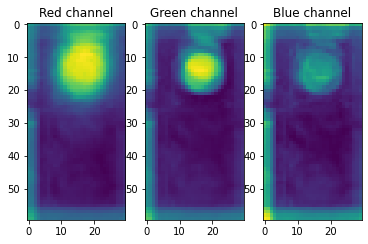

In [6]:
with open('rl_examples.pkl', 'rb') as f:
    rl_examples = pickle.load(f)
with open('non_rl_examples.pkl', 'rb') as f:
    non_rl_examples = pickle.load(f)
    
things_to_av = []
for fname, filter_box in rl_examples:
    I = read_im(fname)
    idx = np.ix_(filter_box[1], filter_box[0],[0, 1, 2])
    things_to_av.append(I[idx] / np.linalg.norm(I[idx]))
    
filt = np.mean(things_to_av, axis=0)
print(np.linalg.norm(filt))
filt /= np.linalg.norm(filt)

Ts = [np.sum(filt * im) for im in things_to_av]
print('Mean inner product with rl examples: ', np.mean(Ts))

non_rl_to_compare = []
for fname, filter_box in non_rl_examples:
    I = read_im(fname)
    idx = np.ix_(filter_box[1], filter_box[0],[0, 1, 2])
    non_rl_to_compare.append(I[idx] / np.linalg.norm(I[idx]))

T2s = [np.sum(filt * im) for im in non_rl_to_compare]
print('Mean inner product with non-rl examples: ', np.mean(T2s))
    
print('Visualizing filter')
fig, axes = plt.subplots(1, 3)
for i in range(3):
    axes[i].imshow(filt[:, :, i])
    axes[i].set_title(['Red', 'Green', 'Blue'][i] + " channel")
    
    
with open('filter.pkl', 'wb') as f:
    pickle.dump(filt, f)

### Take 1 on detection

In [7]:
with open('filter.pkl', 'rb') as f:
    filt = pickle.load(f)
    
    
def keep_best(bboxes, i, j, x, y, score):
    '''
    Ensure we don't have overlapping boxes,
    so only 1 box per red light
    '''
    bbox_copy = bboxes.copy()
    for (i2, j2), score2 in bbox_copy.items():
        if np.abs(i2 - i) <= x and np.abs(j2 - j) <= y:
            # For all boxes intersecting this box, 
            # if the score of the old box is better,
            # return and ignore this box
            if (score2 > score):
                return
            # Otherwise the old box sucks, drop it
            else:
                del bboxes[(i2, j2)]
    bboxes[(i, j)] = score
    

def detect_red_light(I, filt=filt, thresh = 0.85):
    '''
    This function takes a numpy array <I> and returns a list <bounding_boxes>.
    The list <bounding_boxes> should have one element for each red light in the 
    image. Each element of <bounding_boxes> should itself be a list, containing 
    four integers that specify a bounding box: the row and column index of the 
    top left corner and the row and column index of the bottom right corner (in
    that order). See the code below for an example.
    
    Note that PIL loads images in RGB order, so:
    I[:,:,0] is the red channel
    I[:,:,1] is the green channel
    I[:,:,2] is the blue channel
    '''
    
    bounding_boxes0 = {}
     
    x,y,_ = filt.shape
    print(x, y)
    width, height, _ = I.shape
    for i in range(width - x):
        for j in range(height - y):
            I_spliced = I[i:i+x, j:j+y, :]
            assert(I_spliced.shape == filt.shape)
            I2 = I_spliced / np.linalg.norm(I_spliced)
            T = np.sum(I2 * filt)
            if (T > thresh):
                # Keep only the best bounding box per red light
                keep_best(bounding_boxes0, i, j, x, y, T)
                
    bounding_boxes = [[b, a, b + y, a + x] for (a,b) in bounding_boxes0]
    best = max(bounding_boxes, key=lambda x: bounding_boxes0[(x[1], x[0])])
                
    for i in range(len(bounding_boxes)):
        assert len(bounding_boxes[i]) == 4
    
    return bounding_boxes, best

60 30


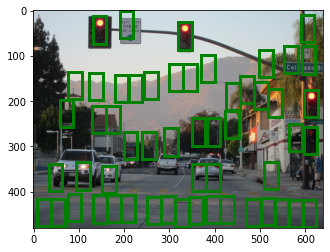

In [9]:
k = 11
preds = {}
#ims = {}
for fname in ['RL-010.jpg']:
    I = read_im(fname)
    plt.imshow(I)
    bboxes, best = detect_red_light(I)
    preds[fname] = bboxes
    
plot_with_bounding_boxes(I, bboxes, ax = plt.gca(), l_width=3);

### Analysis

This way is okay at detecting red lights, but unfortunately detects any region where the bottom pixels are darker, and the top pixels are lighter / red. You can see this for example with the boxes on mountains, where the box intersects the mountains but the top is sky. This is clearly not what we want.

The other issue is this method, where we iterate over every possible box of the same size as the filter in the image is very inefficient. Furthermore, it would only recognize red lights of a particular size. We can iterate over all possible box sizes at all possible locations, but this would be intractable. We need a way of narrowing down what boxes we look at. See better_detect for more!